# Fraud Detection Machine Learning Model

## Adding Explainability with  *Exaplainable AI* (**XAI**) to the Fraud Detection Model

In [16]:
# Loading the models and final dataset
import pandas as pd
import pickle

data = pd.read_csv("processed_data/Fraud_final.csv")

# Load the saved model
with open("saved_models/best_model.pkl", "rb") as f:
    xgb_classifier = pickle.load(f)

with open("saved_models/f_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [19]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Separate features (X) and target variable (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

#Applying feature scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize JS for force plots (needed for notebook visualization)
shap.initjs()

# Create a SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_classifier)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Predict
pred = xgb_classifier.predict(X_test)

## Analytical Plots with Exaplainable AI (XAI) - SHAP

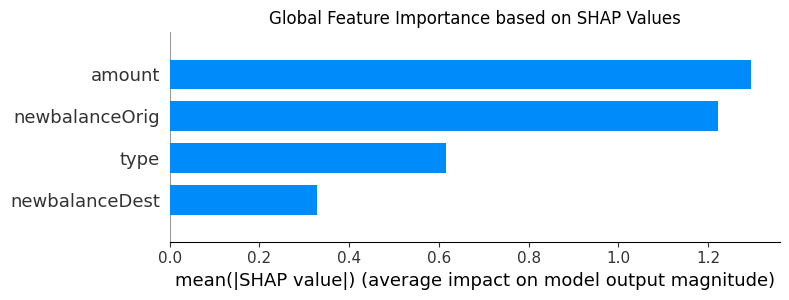

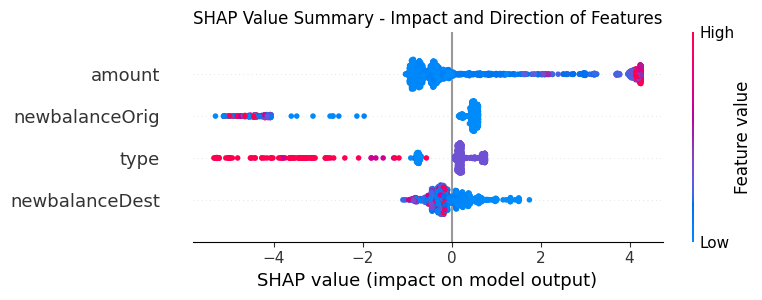

Analyzing transaction at index 0:
Actual value: 1
Predicted probability: 0.9031


<Figure size 1200x600 with 0 Axes>

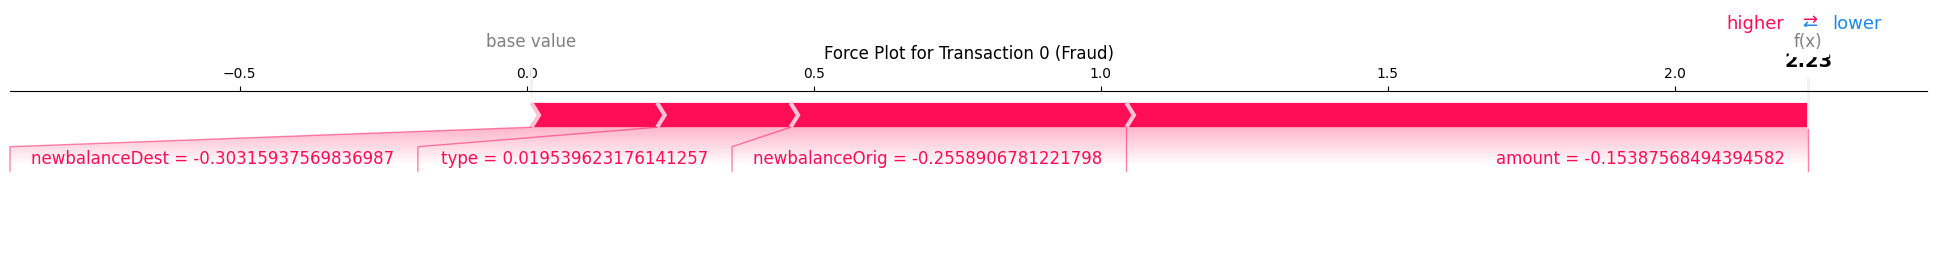


Feature values for this transaction:
type: 0.0195
amount: -0.1539
newbalanceOrig: -0.2559
newbalanceDest: -0.3032


<Figure size 1000x600 with 0 Axes>

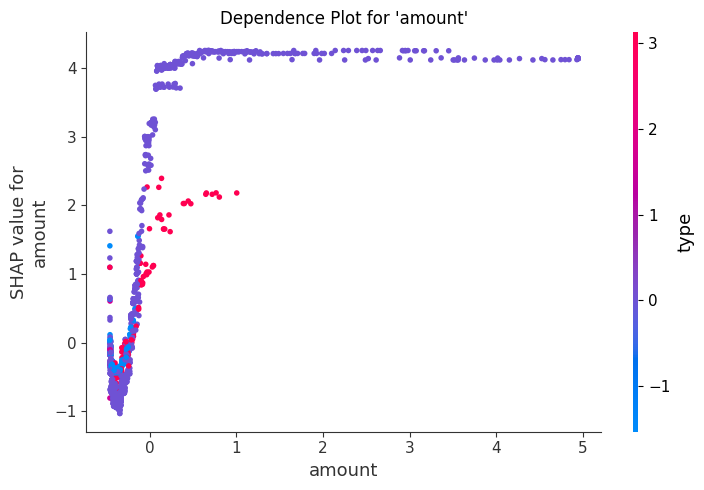

In [18]:
# Define feature names based on your dataset structure

feature_names = ['type', 'amount', 'newbalanceOrig', 'newbalanceDest']

# Global Feature Importance Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global Feature Importance based on SHAP Values")
plt.tight_layout()
plt.show()

# Detailed Summary Plot (shows impact and direction of features)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title("SHAP Value Summary - Impact and Direction of Features")
plt.tight_layout()
plt.show()

# Force Plot for a Specific Prediction, we will examine a specific fraudulent transaction

fraud_indices = np.where(pred == 1)[0]
if len(fraud_indices) > 0:
    # Get the fifth fraudulent prediction
    sample_idx = fraud_indices[0]
    
    print(f"Analyzing transaction at index {sample_idx}:")
    print(f"Actual value: {y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]}")
    print(f"Predicted probability: {xgb_classifier.predict_proba(X_test[sample_idx].reshape(1, -1))[0][1]:.4f}")
    
    # Create force plot for this specific prediction
    plt.figure(figsize=(12, 6))
    shap.force_plot(
        explainer.expected_value, 
        shap_values[sample_idx,:], 
        X_test[sample_idx,:],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f"Force Plot for Transaction {sample_idx} (Fraud)")
    plt.tight_layout()
    plt.show()
    
    # Print feature values for this transaction
    print("\nFeature values for this transaction:")
    for i, feature in enumerate(feature_names):
        print(f"{feature}: {X_test[sample_idx][i]:.4f}")
else:
    print("No fraudulent transactions found in predictions")

# Dependence Plot to Explore Specific Feature Relationships
feature_importance = np.abs(shap_values).mean(0)
most_important_idx = np.argmax(feature_importance)
most_important_feature = feature_names[most_important_idx]

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    most_important_idx, 
    shap_values, 
    X_test, 
    feature_names=feature_names,
    show=False
)
plt.title(f"Dependence Plot for '{most_important_feature}'")
plt.tight_layout()
plt.show()

## Human-Readable Explanations for Fraud Predictions

In [20]:
# Generate Human-Readable Explanations for Fraud Predictions
fraud_indices = np.where(pred == 1)[0]
print(f"\nNumber of transactions flagged as potential fraud: {len(fraud_indices)}")

# Check if we have a scaler object available
try:
    X_test_original = scaler.inverse_transform(X_test)
    scaling_available = True
except NameError:
    scaling_available = False
    X_test_original = X_test 

if len(fraud_indices) > 0:
    print("\nDetailed explanations for flagged transactions (first 5):")
    
    for i, idx in enumerate(fraud_indices[:5]):
        # Get probability score
        proba = xgb_classifier.predict_proba(X_test[idx].reshape(1, -1))[0][1]
        
        print(f"\n--- Transaction #{idx} (Fraud Confidence: {proba:.1%}) ---")
        
        # Get SHAP values for this transaction
        shaps = shap_values[idx]
        
        # Get feature contributions and sort by impact
        feature_contributions = list(zip(feature_names, shaps, X_test_original[idx]))
        feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Print the top reasons
        print("Primary reasons for flagging this transaction:")
        
        for j, (feature, value, original_value) in enumerate(feature_contributions[:3]):
            # Convert feature name to more readable format
            readable_feature = feature.title()
            
            # Domain-specific formatting and interpretation
            if feature == 'type':
                # Map type codes to meaningful descriptions
                type_mapping = {
                    0: 'Cash In',
                    1: 'Cash Out', 
                    2: 'Debit',
                    3: 'Payment',
                    4: 'Transfer'
                }
                type_description = type_mapping.get(int(original_value), f'Unknown ({original_value})')
                formatted_value = type_description
                readable_feature = 'Transaction Type'
                
            elif feature in ['amount', 'newbalanceOrig', 'newbalanceDest']:
                formatted_value = f"${original_value:,.2f}"
                
                # Add more context to these specific features
                if feature == 'amount':
                    readable_feature = 'Transaction Amount'
                elif feature == 'newbalanceOrig':
                    readable_feature = 'Origin Account New Balance'
                elif feature == 'newbalanceDest':
                    readable_feature = 'Destination Account New Balance'
                    
            elif feature == 'isFraud':
                # Skip the target variable in explanations
                continue
            else:
                formatted_value = f"{original_value:.2f}"
            
            # Determine if value is unusually high or low with contextual explanation
            if value > 0:  # Increases fraud probability
                if j == 0:  # Most important factor
                    if feature == 'type':
                        print(f"  1. Transaction type '{formatted_value}' is highly associated with fraudulent activity")
                    else:
                        print(f"  1. {readable_feature} was unusual ({formatted_value})")
                else:
                    if feature == 'type':
                        print(f"  - Transaction type '{formatted_value}' is often linked to fraud")
                    else:
                        print(f"  - {readable_feature} was not the typical value ({formatted_value})")
            else:  # Decreases fraud probability (but still flagged)
                if j == 0:
                    if feature == 'type':
                        print(f"  1. Transaction type '{formatted_value}' is unusual for this account")
                    else:
                        print(f"  1. {readable_feature} was unusual ({formatted_value})")
                else:
                    if feature == 'type':
                        print(f"  - Transaction type '{formatted_value}' is uncommon for this customer")
                    else:
                        print(f"  - {readable_feature} was lower tha typical ({formatted_value})")
        
        # Add contextual interpretation based on the specific features
        print("\n  This transaction exhibits patterns commonly associated with fraudulent activity:")
        
        # Check for specific patterns that might indicate fraud
        orig_balance_idx = feature_names.index('newbalanceOrig') if 'newbalanceOrig' in feature_names else -1
        amount_idx = feature_names.index('amount') if 'amount' in feature_names else -1
        
        if orig_balance_idx >= 0 and amount_idx >= 0:
            orig_balance = X_test_original[idx][orig_balance_idx]
            amount = X_test_original[idx][amount_idx]
            
            if orig_balance == 0 and amount > 0:
                print("  - The origin account was drained to zero balance, which is a common fraud pattern")
            elif amount > orig_balance * 0.9:  # Transaction > 90% of origin balance
                print("  - The transaction amount represents almost the entire balance of the origin account")
        
        # Check for type-specific patterns
        type_idx = feature_names.index('type') if 'type' in feature_names else -1
        if type_idx >= 0:
            transaction_type = int(X_test_original[idx][type_idx])
            if transaction_type in [1, 4]:  # Cash Out or Transfer
                print("  - Cash Out and Transfer transactions have higher fraud rates")
        
        # Add recommendation based on confidence
        if proba > 0.8:
            print("  RECOMMENDATION: Immediate review recommended - high confidence fraud alert.")
            print("  SUGGESTED ACTION: Freeze account and contact customer for verification.")
        elif proba > 0.5:
            print("  RECOMMENDATION: Review recommended - moderate confidence fraud alert.")
            print("  SUGGESTED ACTION: Flag for manual review within 24 hours.")
        else:
            print("  RECOMMENDATION: Consider for review - low confidence alert.")
            print("  SUGGESTED ACTION: Monitor account for additional suspicious activity.")
        
        print("-" * 60)

# Summary statistics
if len(fraud_indices) > 0:
    print("\nFRAUD DETECTION SUMMARY:")
    print(f"Total transactions analyzed: {len(X_test)}")
    print(f"Transactions flagged as potential fraud: {len(fraud_indices)}")
    print(f"Fraud detection rate: {len(fraud_indices)/len(X_test):.2%}")
    
    # Calculate average amount of flagged transactions
    amount_idx = feature_names.index('amount') if 'amount' in feature_names else -1
    if amount_idx >= 0:
        fraud_amounts = [X_test_original[idx][amount_idx] for idx in fraud_indices]
        avg_fraud_amount = sum(fraud_amounts) / len(fraud_amounts) if fraud_amounts else 0
        print(f"Average amount of flagged transactions: ${avg_fraud_amount:,.2f}")
    
    # Most common transaction type among flagged transactions
    type_idx = feature_names.index('type') if 'type' in feature_names else -1
    if type_idx >= 0:
        fraud_types = [int(X_test_original[idx][type_idx]) for idx in fraud_indices]
        if fraud_types:
            type_counts = {}
            for t in fraud_types:
                type_counts[t] = type_counts.get(t, 0) + 1
            
            most_common_type = max(type_counts, key=type_counts.get)
            type_mapping = {0: 'Cash In', 1: 'Cash Out', 2: 'Debit', 3: 'Payment', 4: 'Transfer'}
            type_name = type_mapping.get(most_common_type, f'Unknown ({most_common_type})')
            print(f"Most common transaction type among flags: {type_name} ({type_counts[most_common_type]} cases)")


Number of transactions flagged as potential fraud: 820

Detailed explanations for flagged transactions (first 5):

--- Transaction #0 (Fraud Confidence: 90.3%) ---
Primary reasons for flagging this transaction:
  1. Transaction Amount was unusual ($566,156.42)
  - Origin Account New Balance was not the typical value ($0.00)
  - Transaction type 'Cash Out' is often linked to fraud

  This transaction exhibits patterns commonly associated with fraudulent activity:
  - The origin account was drained to zero balance, which is a common fraud pattern
  - Cash Out and Transfer transactions have higher fraud rates
  RECOMMENDATION: Immediate review recommended - high confidence fraud alert.
  SUGGESTED ACTION: Freeze account and contact customer for verification.
------------------------------------------------------------

--- Transaction #1 (Fraud Confidence: 87.3%) ---
Primary reasons for flagging this transaction:
  1. Destination Account New Balance was unusual ($7,009.93)
  - Origin Acc

## Human-Readable Reports

In [27]:
def generate_fraud_explanation(transaction_id, shap_values, feature_names, feature_values, threshold=0.1):
    """
    Generate a natural language explanation for a fraud prediction
    with domain-specific logic for financial transaction features
    """
    explanation_parts = []
    shaps = shap_values[transaction_id]
    
    # Get top contributing features with their values and SHAP contributions
    contributions = []
    for i, feature in enumerate(feature_names):
        contributions.append({
            'feature': feature,
            'shap_value': shaps[i],
            'actual_value': feature_values[i]
        })
    
    # Sort by absolute contribution magnitude
    contributions.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Add the most influential factors with domain-specific explanations
    for contrib in contributions:
        if abs(contrib['shap_value']) > threshold:
            feature = contrib['feature']
            value = contrib['actual_value']
            shap_val = contrib['shap_value']
            
            # Domain-specific explanations for each feature
            if feature == 'type':
                # Map type codes to meaningful descriptions
                type_mapping = {
                    0: 'Cash In',
                    1: 'Cash Out', 
                    2: 'Debit',
                    3: 'Payment',
                    4: 'Transfer'
                }
                type_desc = type_mapping.get(int(value), f'Unknown Type ({value})')
                if shap_val > 0:
                    explanation_parts.append(f"transaction type was {type_desc} which is associated with higher fraud risk")
                else:
                    explanation_parts.append(f"transaction type was {type_desc} but other factors outweighed this")
                    
            elif feature == 'amount':
                formatted_amount = f"${value:,.2f}"
                if shap_val > 0:
                    explanation_parts.append(f"transaction amount was unusually high ({formatted_amount})")
                else:
                    explanation_parts.append(f"transaction amount was relatively low ({formatted_amount})")
                    
            elif feature == 'newbalanceOrig':
                formatted_balance = f"${value:,.2f}"
                if shap_val > 0:
                    explanation_parts.append(f"origin account balance after transaction was suspiciously low ({formatted_balance})")
                else:
                    explanation_parts.append(f"origin account maintained sufficient balance ({formatted_balance})")
                    
            elif feature == 'newbalanceDest':
                formatted_balance = f"${value:,.2f}"
                if shap_val > 0:
                    explanation_parts.append(f"destination account received unusually large amount ({formatted_balance})")
                else:
                    explanation_parts.append(f"destination account received a suspicious amount ({formatted_balance})")
    
    # Add pattern-based explanations
    orig_balance = next((c['actual_value'] for c in contributions if c['feature'] == 'newbalanceOrig'), None)
    amount = next((c['actual_value'] for c in contributions if c['feature'] == 'amount'), None)
    
    if orig_balance is not None and amount is not None:
        if orig_balance == 0 and amount > 0:
            explanation_parts.append("origin account was completely drained by this transaction")
        elif amount > orig_balance * 0.9:
            explanation_parts.append("transaction represented almost the entire balance of the origin account")
    
    # Construct the final explanation
    if explanation_parts:
        return "This transaction was flagged as potentially fraudulent because: " + "; ".join(explanation_parts) + "."
    else:
        return "This transaction was flagged, but no single factor stood out as strongly suspicious."

## Example for any Random Transaction ID

In [28]:
# Get the actual feature values for a specific transaction
transaction_idx = fraud_indices[17]  # fraudulent transaction No (could be changed to any number)
actual_values = X_test_original[transaction_idx]  # Make sure this contains the unscaled values

# Generate the explanation
explanation = generate_fraud_explanation(
    transaction_idx, 
    shap_values, 
    feature_names, 
    actual_values
)

print(explanation)

This transaction was flagged as potentially fraudulent because: destination account received a suspicious amount ($2,396,494.70); transaction amount was unusually high ($607,684.02); origin account balance after transaction was suspiciously low ($0.00); transaction type was Cash Out which is associated with higher fraud risk; origin account was completely drained by this transaction.
